*Data preprocessing and Augmentation*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from ctgan import CTGAN

In [2]:
data = pd.read_csv('mean_values.csv').drop(columns=['edge_count'])

In [3]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.head()

,person,object,speed,frames
0,11.302885,0.283654,1.403075,208.0
1,1.140000,0.560000,2.374617,50.0
2,1.943329,0.741440,0.669307,847.0
3,1.000863,1.316652,0.796265,1159.0
4,1.000000,0.000000,0.000000,1.0


In [5]:
data.info()
# ~600 is a decent sample for a very small project

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   person  627 non-null    float64
 1   object  627 non-null    float64
 2   speed   627 non-null    float64
 3   frames  627 non-null    float64
dtypes: float64(4)
memory usage: 19.7 KB


In [6]:
# Some samples are the product of error in seperating frames. Single images do not help us in any way 
data = data[data['frames'] >= 3]

In [7]:
data.shape

(583, 4)

In [8]:
# Duplicated data is more than 30% of the sample. We can process it and add it back as augmentation. 
data[data.duplicated()].shape

(250, 4)

In [9]:
dupe_data = data[data.duplicated()]
data = data[~data.duplicated()]

In [10]:
dupe_data.shape

(250, 4)

In [11]:
# Lets produce some nose to the dupe_data and add it back to the whole set
noise = np.random.normal(loc=0.0, scale=0.1, size=dupe_data.shape)

In [12]:
dupe_data[:] = dupe_data + noise

In [13]:
dupe_data.shape

(250, 4)

In [14]:
data = pd.concat([data, dupe_data])

In [15]:
data.shape

(583, 4)

In [16]:
# Up until now we have independant variables but we do not have a dependan. For that purpose we will use another set, perform k-means clustering and assign the time 
# our data based on the similarity between the clusters formed

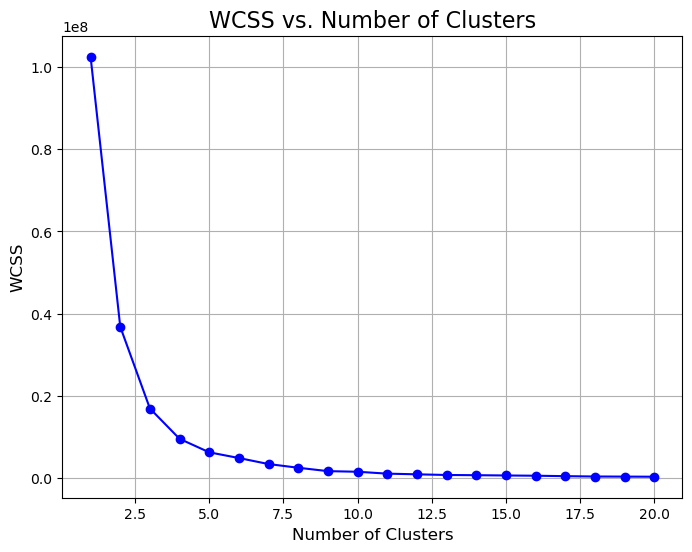

In [17]:
# caclulate and plot the WCSS score

wcss = []
for i in range(1, 21):  
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_) 

    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), wcss, marker='o', color='blue')
plt.title('WCSS vs. Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.grid(True)
plt.show()

# Seems that our data would perform perfect with 4 clusters

In [18]:
# Assign the clusters to each entry 
data['cluster'] = kmeans.labels_

In [19]:
# Lets read the times.xlsx
times = pd.read_excel('times.xlsx')
times.head()

,clip,person,object,speed,frames,time
0,XTYPOKARDIA_3_17.csv,11.899598,1.120482,2.280924,249,30.000
1,XTYPOKARDIA_3_31.csv,6.781250,0.117188,0.633078,128,23.875
2,XTYPOKARDIA_5_1.csv,1.742126,1.259843,0.611253,508,11.000
3,XTYPOKARDIA_4_6.csv,6.930636,3.273603,1.031845,519,38.250
4,XTYPOKARDIA_3_2.csv,1.836538,0.596154,0.804558,416,14.000


In [20]:
# Clip name is not needed
times.drop(columns=['clip'], inplace=True)

In [21]:
times.shape

(44, 5)

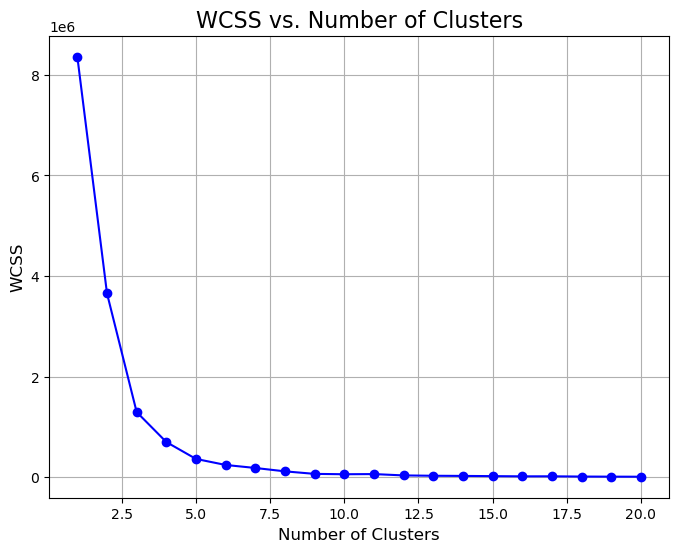

In [22]:
wcss = []
for i in range(1, 21):  
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(times)
    wcss.append(kmeans.inertia_) 

    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), wcss, marker='o', color='blue')
plt.title('WCSS vs. Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.grid(True)
plt.show()



# Looks like the times df performs better on 5 clusters. We will use 9 clusters for grouping the data and finding the mean values of the features, in each cluster
# Choice of clusters has to do with the difference in the order of magnitude -> WCSS gets to the same order of magnitude at about 9 clusters
# Normally, we follow the elbow rule

In [23]:
times['cluster'] = KMeans(n_clusters=9).fit(times).labels_
data['cluster'] = KMeans(n_clusters=9).fit(data).labels_


In [24]:
# Time is in hours. We should convert it to minutes
# FPM will be useful for assigning the times to our data
times['time'] *= 60
times['FPM'] = times['frames'] / times['time']

In [25]:
# Calculate the mean FPM for each cluster
group = times.groupby('cluster').mean().reset_index()
group

,cluster,person,object,speed,frames,time,FPM
0,0,3.536414,1.106910,2.482794,277.222222,1290.033333,0.382929
1,1,3.095479,1.758986,0.929298,868.857143,2186.785714,0.420556
2,2,2.209658,1.297677,1.137528,1636.000000,2274.000000,0.719437
3,3,1.025991,1.711454,0.450969,2270.000000,1575.000000,1.441270
4,4,2.260664,0.921157,1.725340,484.111111,1567.500000,0.369140
5,5,9.194319,1.269674,1.745092,117.285714,1734.642857,0.076725
6,6,1.502810,1.395878,0.966849,652.571429,1514.785714,0.524806
7,7,2.793127,3.903639,0.730092,1484.000000,1785.000000,0.831373
8,8,2.729501,2.882991,1.022401,1065.000000,2085.000000,0.510645


In [26]:
data.groupby('cluster').mean()

,person,object,speed,frames
cluster,,,,
0,3.635330,1.644603,1.249182,557.121862
1,2.919783,1.892180,0.965398,1277.168948
2,3.148110,1.288129,1.134683,422.828432
3,5.522627,1.034516,1.537460,98.129556
4,2.987146,1.408005,0.844186,1823.711414
5,3.237110,1.544958,0.848811,912.900427
6,5.269398,1.476138,1.419123,209.031570
7,3.266946,1.584246,0.960432,705.007753
8,4.544559,1.217826,1.597773,288.306563


In [27]:
data_wtimes = pd.merge(data, group[['cluster', 'FPM']], on='cluster', how='left')

In [28]:
data_wtimes['time'] = data_wtimes['frames'] / data_wtimes['FPM'] /60 # to convert to hours
data = data_wtimes.drop(columns=['FPM', 'cluster'])
data

,person,object,speed,frames,time
0,11.302885,0.283654,1.403075,208.000000,6.605610
1,1.140000,0.560000,2.374617,50.000000,0.578194
2,1.943329,0.741440,0.669307,847.000000,183.989848
3,1.000863,1.316652,0.796265,1159.000000,45.931293
4,2.747253,0.957418,1.098094,728.000000,14.594340
...,...,...,...,...,...
578,1.793970,1.276752,3.596711,233.086170,7.402290
579,7.975507,0.265668,2.049348,1331.778942,52.778540
580,2.589375,1.300078,0.896945,1179.829936,46.756785
581,1.000716,0.828516,0.791769,328.952991,10.736513


In [29]:
# Up until now we have created the time variable which will be the dependant one in our traning set.
data.describe()

,person,object,speed,frames,time
count,583.000000,583.000000,583.000000,583.000000,583.000000
mean,3.902419,1.439387,1.197354,585.499006,42.923500
std,3.316930,1.188227,0.692453,419.671169,65.298633
min,0.000000,-0.057398,0.245260,25.000000,0.289097
25%,1.740310,0.615833,0.714771,253.035491,8.240972
50%,2.822919,1.227273,1.016452,515.163382,12.989947
75%,4.763558,1.908277,1.419608,812.012779,44.187568
max,22.167513,9.790383,3.879154,2270.000000,232.433950


In [30]:
# There are certainly outliers in this adjustment - no clip can be done in as little time as less than 4 hours or more than 80.
# We will drop negative values and outliers in time

data = data[(data['time'].between(5, 80))]
data = data[(data[data.columns] > 0)]
data.describe()

,person,object,speed,frames,time
count,409.000000,400.000000,410.000000,410.000000,410.000000
mean,3.755503,1.543544,1.215630,579.729214,19.231069
std,3.110820,1.248269,0.695644,358.284643,16.171987
min,0.003922,0.013245,0.265931,164.000000,5.208269
25%,1.811989,0.727655,0.737708,312.975705,9.150748
50%,2.854717,1.292979,1.037721,503.045676,12.840954
75%,4.354890,1.993615,1.423016,683.000000,24.128471
max,22.167513,9.790383,3.879154,1756.080484,79.287028


In [31]:
# We lost quite some samples. 
# From now on we can use many methods to augment our data. Sometimes its needed to fills samples when dataset is too small for ML or ANN development
# In this case it is too small for ANN development (as well as hardware shortages) and we need to make it a little bigger of better ML accuracy.
# Note that we have already augmented it a little bit by ntroducing noise to the data set -> changed the duplicated values and added them back in
# We will use a Generative Adversarial Network (GAN) named ctgan

# There are other GANs available for tabular data as well as for categorical, pictural and label data.

In [32]:
data

,person,object,speed,frames,time
0,11.302885,0.283654,1.403075,208.000000,6.605610
3,1.000863,1.316652,0.796265,1159.000000,45.931293
4,2.747253,0.957418,1.098094,728.000000,14.594340
5,2.543018,0.853315,0.812481,709.000000,14.213443
6,2.282511,1.394619,0.493940,446.000000,10.332152
...,...,...,...,...,...
578,1.793970,1.276752,3.596711,233.086170,7.402290
579,7.975507,0.265668,2.049348,1331.778942,52.778540
580,2.589375,1.300078,0.896945,1179.829936,46.756785
581,1.000716,0.828516,0.791769,328.952991,10.736513


In [33]:
# Due to lack of hardware resources we will run it for 50 epochs only.
# 

In [34]:
ctgan = CTGAN(epochs=50, verbose=True, batch_size=250)
ctgan.fit(data, data.iloc[:, :-1])

Gen. (6.07) | Discrim. (-0.02): 100%|████████████████| 50/50 [00:48<00:00,  1.03it/s]


In [35]:
synthetic_data = ctgan.sample(500)

In [36]:
synthetic_data

,person,object,speed,frames,time
0,1.635488,1.457649,1.117699,477.944481,12.392683
1,4.708029,0.802817,0.606909,558.000000,6.131337
2,2.970642,1.769042,1.419364,554.808074,11.329917
3,0.446169,1.992116,0.800632,232.025794,12.298648
4,4.159763,0.998052,0.678180,580.000000,13.213727
...,...,...,...,...,...
495,1.085714,0.607330,1.023180,397.000000,6.518935
496,4.007194,0.300940,1.138112,257.108738,12.456447
497,4.642736,2.060403,0.791769,318.000000,12.489347
498,1.004739,0.499377,0.627537,1684.956448,11.786987


In [37]:
data = pd.concat([data, synthetic_data], axis=0, ignore_index=True).reset_index(drop=True)

In [38]:
data

,person,object,speed,frames,time
0,11.302885,0.283654,1.403075,208.000000,6.605610
1,1.000863,1.316652,0.796265,1159.000000,45.931293
2,2.747253,0.957418,1.098094,728.000000,14.594340
3,2.543018,0.853315,0.812481,709.000000,14.213443
4,2.282511,1.394619,0.493940,446.000000,10.332152
...,...,...,...,...,...
905,1.085714,0.607330,1.023180,397.000000,6.518935
906,4.007194,0.300940,1.138112,257.108738,12.456447
907,4.642736,2.060403,0.791769,318.000000,12.489347
908,1.004739,0.499377,0.627537,1684.956448,11.786987


In [40]:
data.to_csv('training_set_synth.csv', index=False)